In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


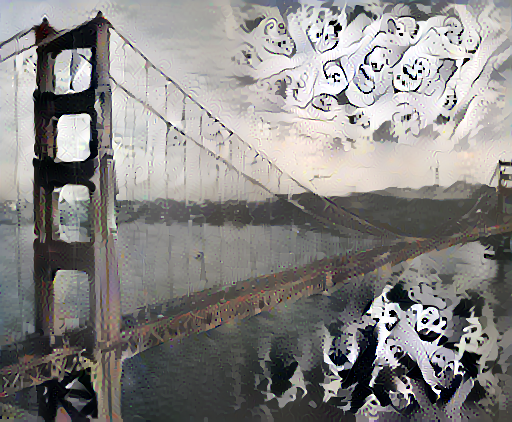

Epoch 30/30 completed
SSIM between generated and content image: [0.39438364]
SSIM between generated and style image: [0.14643085]
PSNR between generated and content image: [14.24374]
PSNR between generated and style image: [8.414478]


In [5]:
import tensorflow as tf
#import tensorflow_addons as tfa
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time
import functools
import os
import copy


#Պատկերելու համար նկարները tensor-ից սարքում ենք PIL
def tensor_to_image(tensor):
    #0-1 թիվը սարքում ենք 0-255
    tensor = tensor * 255
    #բերում ենք np-ի fromarray() ֆունկցիայի համար
    tensor = np.array(tensor, dtype=np.uint8)
    #եթե [batch_size, height, width, channels] է [height, width, channels]-ի փոխարեն
    if np.ndim(tensor) > 3:
        #վերցնում ենք մենակ առաջին նկարը
        tensor = tensor[0]
    #սրանից հետո կարանք ցուցադրենք և պահենք որպես նկար
    return PIL.Image.fromarray(tensor)

#Ֆայլից նկարը ստանալու համար
def load_img(path_to_img, img_size):
    #կարդում ենք նկարը
    img = tf.io.read_file(path_to_img)
    #ստանում ենք tensor 3 channel-ներով, RGB-ի համար
    img = tf.image.decode_image(img, channels=3)
    #tf.float32 տիպի ենք բերում, քանի որ TensorFlow image processing
    #օպերատորները դրա հետ ավելի լավ են աշխատում քան 0-255 թվերի
    img = tf.image.convert_image_dtype(img, tf.float32)
    #նկարի չափերն ենք փոխում
    img = tf.image.resize(img, img_size)
    #ավելացնում ենք batch dimension, քանի որ NN-ները տենց են սպասում,
    #ստանում է (1, height, width, 3) տեսք
    img = img[tf.newaxis, :]
    return img

#Custom VGG19 մոդել ստեղծելու համար pre-trained VGG19-ից
def vgg_layers(layer_names):
    #ներբեռնում ենք pre-trained VGG19-ը առանց fully connected layer-ների,
    #ImageNet dataset-ի վրա սովորած
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    #նշում ենք, որ weight-երը չթարմանան
    vgg.trainable = False
    #ստանում ենք նշված շերտերը մոդելից
    outputs = [vgg.get_layer(name).output for name in layer_names]
    #նոր մոդել ենք ստեղծում, քանի որ ինքը նախատեսված էր կլասիֆիկացիայի համար,
    #իսկ մեզ պետք է հատկանիշները հանել
    model = tf.keras.Model([vgg.input], outputs)
    return model

#Gram matrix հաշվելու համար, ցույց է տալիս correlation-ը (գծային կախվածությունը
#երկու փոփոխականների) feature map-երի միջև
def gram_matrix(input_tensor):
    #Einstein summation notation օգտագործելով հաշվում ենք ամեն նկարի համար
    #Gram matrix, (batch_size, channels, channels) չափերով
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    #հաշվում ենք պիքսելների ընդհանուր քանակը, բերում float32 ֆորմատի
    num_locations = tf.cast(input_tensor.shape[1]*input_tensor.shape[2], tf.float32)
    #նորմալիզացված Gram matrix ստանալու համար
    return result / num_locations

#SSIM և PSNR հաշվելու համար
def calculate_similarity_metrics(generated_image, content_image, style_image):
    #SSIM-ի հաշվարկ բովանդակության նկարի համար
    ssim_content = tf.image.ssim(generated_image, content_image, max_val=1.0)
    #SSIM-ի հաշվարկ ոճի նկարի համար
    ssim_style = tf.image.ssim(generated_image, style_image, max_val=1.0)
    #PSNR-ի հաշվարկ բովանդակության նկարի համար
    psnr_content = tf.image.psnr(generated_image, content_image, max_val=1.0)
    #PSNR-ի հաշվարկ բովանդակության նկարի համար
    psnr_style = tf.image.psnr(generated_image, style_image, max_val=1.0)
    return ssim_content, ssim_style, psnr_content, psnr_style

#ՀԻպերպարամետրեր
#վերջնական նկարի փափկության և առանց աղմուկ աշխատանքի կշիռ
total_variation_weight = 30
#ոճի նկարի կշիռ
style_weight=1e-2
#բովանդակության նկարի կշիռ
content_weight=1e4
#նկարի չափեր
img_size = (422, 512)

#Նկարների ներբեռնում
content_path = "/content/golden_gate.jpg"
#style_path = "/content/VG.jpg"
style_path = "/content/Arev_cats.jpg"
content_image = load_img(content_path, img_size)
style_image = load_img(style_path, img_size)

#Թե որ շերտերն ենք pre-trained VGG19-ից օգտագործում
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

#Մոդելի կլասս, հատկանիշների դուրս բերման համար
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        #ծնող կլասի կոնստրուկտորի կանչ
        super(StyleContentModel, self).__init__()
        #vgg մոդելի ստացում, մեր նշած շերտերով
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        #ոճի շերտերի քանակի որոշում, օգտագորշվելու է արդյունքները բաժանելիս
        self.num_style_layers = len(style_layers)
        #նշում ենք որ weight-երը չենք փոխում
        self.vgg.trainable = False

    #Մոդելի forward pass
    def call(self, inputs):
        #0-1 թվերը բերում է 0-255 տեսքի
        inputs = inputs * 255.0
        #նախնական մշակում
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        #ստանում ենք feature maps ցուցակ, շերտերի քանակին հավասար
        outputs = self.vgg(preprocessed_input)
        #բաժանում ենք համապատասպխան մասերի
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        #ամեն արդյունքի համար Gram matrix ենք հաշվում
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        #ստեղծում է բառարան շերտի անունով և feature map-երով, կօգտագործվի content loss հաշվելիս
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        #ստեղծում է բառարան շերտի անունով և feature map-երով, կօգտագործվի content style հաշվելիս
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

#Մոդելի ստեղծում և կանչ
#ստեղծում ենք կլասի օբյեկտ
extractor = StyleContentModel(style_layers, content_layers)
#պահում ենք ոճին առնչվող արդյունքները
style_targets = extractor(style_image)['style']
#պահում ենք բովանդակությանը առնչվող արդյունքները
content_targets = extractor(content_image)['content']
#TensorFlow փոփոխական ենք սարքում, սկբնական արժեք տալով բովանդակության նկարը
image = tf.Variable(content_image)

#Արժեքները բերում է 0-1 միջակայք
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#Օպտիմիզացիա
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#Կորուստների հաշվարկ (և ոճի, և բովանդակության )
def style_content_loss(outputs):
    #պահում ենք ոճին առնչվող արդյունքները
    style_outputs = outputs['style']
    #պահում ենք բովանդակությանը առնչվող արդյունքները
    content_outputs = outputs['content']
    #միջին քառակուսային սխալանքի օգնությամբ հաշվում ենք ոճի կորուստը
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    #քաշերով մաշտաբավորում ենք և նորմալիզացնում
    style_loss *= style_weight / len(style_layers)
    #միջին քառակուսային սխալանքի օգնությամբ հաշվում ենք բովանդակության կորուստը
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    #քաշերով մաշտաբավորում ենք և նորմալիզացնում
    content_loss *= content_weight / len(content_layers)
    #վերադարձնում ենք կորուստների գումարը
    return style_loss + content_loss

#ֆունկցիան նշում ենք որպես TensorFlow graph, արագ և էֆֆեկտիվ իրականացնելով
@tf.function()
#Ուսուցումն իրականացնող ֆունկցիա
def train_step(image):
    #գրառում ենք գործողությունները գրադիենտ հաշվելու, ներգործությունը գնահատելու համար
    with tf.GradientTape() as tape:
        #հատկանիշների ստացում
        outputs = extractor(image)
        #սխալանքի հաշվում
        loss = style_content_loss(outputs)
        #ավելացնում ենք ընդհանուր վարիացիայի սխալը ավելի սահուն նկարի համար
        loss += total_variation_weight * tf.image.total_variation(image)
    #գրադիենտի հաշվարկ
    grad = tape.gradient(loss, image)
    #օպտիմիզացիա
    opt.apply_gradients([(grad, image)])
    #բերում ենք 0-1 միջակայքի
    image.assign(clip_0_1(image))

#Ուսուցման պարամետրեր
epochs = 30
steps_per_epoch = 100

#Աշխատացնում ենք և ցուցադրում
for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    #SSIM-ի և PSNR-ի հաշվարկ
    ssim_content, ssim_style, psnr_content, psnr_style = calculate_similarity_metrics(image, content_image, style_image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Epoch {n+1}/{epochs} completed")
    print(f"SSIM between generated and content image: {ssim_content.numpy()}")
    print(f"SSIM between generated and style image: {ssim_style.numpy()}")
    print(f"PSNR between generated and content image: {psnr_content.numpy()}")
    print(f"PSNR between generated and style image: {psnr_style.numpy()}")
